In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
!pip install tensorflow==1.15
!pip install keras==2.3.0
import keras
import keras.models as models
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import BatchNormalization, Input, Add, Concatenate, concatenate
from keras.layers import TimeDistributed, LSTM
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import model_from_json, load_model
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from keras.callbacks import ModelCheckpoint
import cv2
import os
import csv
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
from keras.callbacks import CSVLogger
from keras.engine.topology import Layer
import keras.backend as K
import tensorflow as tf

In [5]:
steering = (10,20)
minS = 15
maxS = 15.7
n = 2

In [6]:
def load_images(path):
    # initialize loop variables
    numImages = 0
    inputs = []
    processDataPath = path + "ProcessData.csv"
    if not os.path.isfile(processDataPath):
        print('ProcessData.csv must be in folder %s' %path)
        return
    # read images in ProcessData.csv and append to input
    with open(processDataPath, 'rt') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            numImages = numImages+1
            if not os.path.isfile(path + (row[0].lower())):
                print('%s not found.' %(path+(row[0].lower())))
                return
            image=cv2.imread(path + (row[0].lower()))
            img = cv2.resize(image, (200, 66))
            img = img / 255.
            inputs.append(img)
    print("Total number of images: %d" %numImages)
    return inputs

In [7]:
def read_output_data(path):
    Y=[]
    # ensure path exists
    processDataPath = path+"ProcessData.csv"
    if not os.path.isfile(processDataPath):
        print('ProcessData.csv not found in %s.' %path)
        return
    # open ProcessData.csv and append steering values and speeds to Y and A
    with open(processDataPath, 'rt') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            s = (float(row[1]) - steering[0]) / (steering[1] - steering[0])
            Y.append([s])
    # return list of steering values and speeds
    return Y

In [8]:
def loadData(path):
    X = load_images(path)
    Y = read_output_data(path)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [9]:
def split_sequence(sequence, n_steps):
  x = list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence) - 1:
      break
    seq_x = sequence[i:end_ix]
    x.append(seq_x)
  return np.array(x)

In [10]:
train_path = '/content/drive/My Drive/Colab Notebooks/DAVE-II-Hunter/DeepNNCar_Train2/'
X, Y = loadData(train_path)

print(X.shape)
print(Y.shape)

Total number of images: 1604
(1604, 66, 200, 3)
(1604, 1)


In [11]:
outputs = []
for i in range(Y.shape[0]):
  l = [0] * 10
  if Y[i][0] < 0.1:
    l[0] = 1
  elif Y[i][0] < 0.2:
    l[1] = 1
  elif Y[i][0] < 0.3:
    l[2] = 1
  elif Y[i][0] < 0.4:
    l[3] = 1
  elif Y[i][0] < 0.5:
    l[4] = 1
  elif Y[i][0] < 0.6:
    l[5] = 1
  elif Y[i][0] < 0.7:
    l[6] = 1
  elif Y[i][0] < 0.8:
    l[7] = 1
  elif Y[i][0] < 0.9:
    l[8] = 1
  else:
    l[9] = 1
  outputs.append(l)
train_X = X
train_Y = np.array(outputs)
print(train_X.shape)
print(train_Y.shape)

(1604, 66, 200, 3)
(1604, 10)


In [12]:
class RBFLayer(Layer):
    def __init__(self, units, gamma, temp=None,**kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)
        self.temp = temp
    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=1234),
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        if (self.temp):
            diff = diff / self.temp
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(0.0)*l2
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'units': self.units,
            'gamma': self.gamma
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


# this is a helper function
def softargmax(x,beta=1e10):
    """
    Perform argmax in a differential manner
    :param x: An array with the original inputs. `x` is expected to have spatial dimensions.
    :type x: `np.ndarray`
    :param beta: A large number to approximate argmax(`x`)
    :type y: float
    :return: argmax of tensor
    :rtype: `tensorflow.python.framework.ops.Tensor`
    """
    x = tf.convert_to_tensor(x)
    x_range = tf.range(10)
    x_range = tf.dtypes.cast(x_range,tf.float32)
    return tf.reduce_sum(tf.nn.softmax(x*beta) * x_range, axis=1)

RBF_LAMBDA = 0.5
def RBF_Soft_Loss(y_true,y_pred):
    lam = RBF_LAMBDA
    indices = softargmax(y_true)
    indices = tf.dtypes.cast(indices,tf.int32)
    y_pred = tf.dtypes.cast(y_pred,tf.float32)
    y_true = tf.dtypes.cast(y_true,tf.float32)
    row_ind = K.arange(K.shape(y_true)[0])
    full_indices = tf.stack([row_ind,indices],axis=1)
    d = tf.gather_nd(y_pred,full_indices)
    y_pred = K.log(1+ K.exp(lam - y_pred))
    S = K.sum(y_pred,axis=1) - K.log(1+K.exp(lam-d))
    y = K.sum(d + S)
    return y

def DistanceMetric(y_true,y_pred):
    e  = K.equal(K.argmax(y_true,axis=1),K.argmin(y_pred,axis=1))
    s = tf.reduce_sum(tf.cast(e, tf.float32))
    n = tf.cast(K.shape(y_true)[0],tf.float32)
    return s/n

In [13]:
class DaveIIModel():
    def __init__(self,anomalyDetector=False):
        self.input_size = (66, 200, 3)
        self.num_classes = 10
        self.isAnomalyDetector = anomalyDetector
        model = Sequential()
        input1= Input(shape=(66,200,3), name='image')
        steer_inp = BatchNormalization(epsilon=0.001, axis=-1,momentum=0.99)(input1)
        layer1 = Conv2D(24, (5, 5), padding="valid", strides=(2, 2), activation="relu")(steer_inp)
        layer2 = Conv2D(36, (5, 5), padding="valid", strides=(2, 2), activation="relu")(layer1)
        layer3 = Conv2D(48, (5, 5), padding="valid", strides=(2, 2), activation="relu")(layer2)
        layer4 = Conv2D(64, (3, 3), padding="valid", strides=(1, 1), activation="relu")(layer3)
        layer5 = Conv2D(64, (3, 3), padding="valid", strides=(1, 1))(layer4) # add relu for old time sake
        layer6 = Flatten()(layer5)
        if(anomalyDetector):
            layer7 = Activation('tanh')(layer6)
            prediction = RBFLayer(self.num_classes,0.5)(layer7)
            model=Model(inputs=input1, outputs=prediction)
            model.summary()
            model.compile(loss=RBF_Soft_Loss,optimizer=keras.optimizers.Adam(),metrics=[DistanceMetric])
        else:
            layer6 = Activation('relu')(layer6) # remove me for old time sake
            layer7 = Dense(1164, activation='relu')(layer6)
            layer8 = Dense(100, activation='relu')(layer7)
            layer9 = Dense(50, activation='relu')(layer8)
            layer10 = Dense(10, activation='relu')(layer9)
            prediction = Dense(10, name='predictions',activation="softmax")(layer10)
            model=Model(inputs=input1, outputs=prediction)
            model.summary()
            model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
        self.model = model

    def predict(self,X):
        predictions = self.model.predict(X)
        if (self.isAnomalyDetector):
            lam = RBF_LAMBDA
            Ok = np.exp(-1*predictions)
            top = Ok*(1+np.exp(lam)*Ok)
            bottom = np.prod(1+np.exp(lam)*Ok,axis=1)
            predictions = np.divide(top.T,bottom).T
        return predictions

    def getInputSize(self):
        return self.input_size

    def getNumberClasses(self):
        return self.num_classes

    def train(self,train_data_generator,validation_data_generator,saveTo,epochs=10,class_weight=None):

        if (self.isAnomalyDetector):
            checkpoint = ModelCheckpoint(saveTo, monitor='DistanceMetric', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
        else:
            checkpoint = ModelCheckpoint(saveTo, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        self.model.fit_generator(
            train_data_generator,
            steps_per_epoch = math.ceil(train_data_generator.samples/train_data_generator.batch_size),
            epochs = epochs,
            validation_data = validation_data_generator,
            validation_steps = math.ceil(validation_data_generator.samples/validation_data_generator.batch_size),
            callbacks = [checkpoint],
            class_weight=class_weight)

    def train_data(self,X,Y,saveTo,epochs=10,class_weight=None):
        if (self.isAnomalyDetector):
            checkpoint = ModelCheckpoint(saveTo, monitor='DistanceMetric', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
        else:
            checkpoint = ModelCheckpoint(saveTo, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        self.model.fit(X, Y,
                batch_size=8,
                epochs=epochs,
                verbose=1,
                callbacks=[checkpoint],
                shuffle=True)

    def load(self,weights):
        if (self.isAnomalyDetector):
            self.model = load_model(weights, custom_objects={'RBFLayer': RBFLayer,'DistanceMetric':DistanceMetric,'RBF_Soft_Loss':RBF_Soft_Loss})
        else:
            self.model = load_model(weights)

    def evaluate(self,X,Y):
        predictions = self.predict(X)
        accuracy = np.sum(np.argmax(predictions,axis=1) == np.argmax(Y, axis=1)) / len(Y)
        print('The accuracy of the model: ', accuracy)
        mse = mean_squared_error(np.argmax(Y, axis=1),np.argmax(predictions,axis=1))
        print('MSE of model: ', mse)
        print('Number of samples: ', len(Y))
    
    def evaluate_with_reject(self,X,Y):
        predictions = self.predict_with_reject(X)
        accuracy = np.sum(np.argmax(predictions,axis=1) == np.argmax(Y, axis=1)) / len(Y)
        print('The accuracy of the model: ', accuracy)
        mse = mean_squared_error(np.argmax(Y, axis=1),np.argmax(predictions,axis=1))
        print('MSE of model: ', mse)
        print('Number of samples: ', len(Y))
    
    def predict_with_reject(self,X):
        assert self.isAnomalyDetector, \
            print('Cannot reject a softmax classifier')
        predictions = self.model.predict(X)
        lam = RBF_LAMBDA
        Ok = np.exp(-1*predictions)
        bottom = np.prod(1+np.exp(lam)*Ok,axis=1)
        reject = 1.0/bottom
        top = Ok*(1+np.exp(lam)*Ok)
        predictions = np.divide(top.T,bottom).T
        predictions = np.concatenate((predictions,np.expand_dims(reject,axis=1)),axis=1)
        return predictions
    
    def reject(self,X):
        assert self.isAnomalyDetector, \
            print('Cannot reject a softmax classifier')
        predictions = self.model.predict(X)
        lam = RBF_LAMBDA
        Ok = np.exp(-1*predictions)
        bottom = np.prod(1+np.exp(lam)*Ok,axis=1)
        return 1.0/bottom



In [14]:
rbf_model = DaveIIModel(anomalyDetector=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           (None, 66, 200, 3)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 200, 3)        12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
____________________________________________

In [15]:
MODEL_WEIGHT_LOC ='/content/drive/My Drive/Colab Notebooks/pretrained_weights/'
K.set_value(rbf_model.model.optimizer.lr,0.0001)
rbf_model.train_data(train_X, train_Y, saveTo=os.path.join(MODEL_WEIGHT_LOC,'DaveII_rbf_model.h5'),epochs=300)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/300
1604/1604 [==============================] - 8s 5ms/step - loss: 2952.3125 - DistanceMetric: 0.2556

Epoch 00001: DistanceMetric improved from -inf to 0.25560, saving model to /content/drive/My Drive/Colab Notebooks/pretrained_weights/DaveII_rbf_model.h5
Epoch 2/300
1604/1604 [==============================] - 1s 876us/step - loss: 2733.5427 - DistanceMetric: 0.4614

Epoch 00002: DistanceMetric improved from 0.25560 to 0.46144, saving model to /content/drive/My Drive/Colab Notebooks/pretrained_weights/DaveII_rbf_model.h5
Epoch 3/300
1604/1604 [==============================] - 1s 872us/step - loss: 2535.2836 - DistanceMetric: 0.4795

Epoch 00003: DistanceMetric improved from 0.46144 to 0.47948, saving model to /content/drive/My Drive/Colab Notebooks/pretrained_weights/DaveII_rbf_model.h5
Epoch 4/300
1604/1604 [==============================] - 1s 867us/step - loss: 2362.3568 - Dis

In [16]:
test_path = '/content/drive/My Drive/Colab Notebooks/DAVE-II-Hunter/DeepNNCar_Train1/'
X_test, Y_test = loadData(test_path)

print(X_test.shape)
print(Y_test.shape)

Total number of images: 1076
(1076, 66, 200, 3)
(1076, 1)


In [17]:
old_results = rbf_model.reject(X_test)
print(old_results.mean())

0.5555693


In [51]:
from google.colab.patches import cv2_imshow
from skimage.util import random_noise
def load_images_2(path):
    # initialize loop variables
    numImages = 0
    new_images = []
    alpha = 1
    beta = 200
    processDataPath = path + "ProcessData.csv"
    if not os.path.isfile(processDataPath):
        print('ProcessData.csv must be in folder %s' %path)
        return
    # read images in ProcessData.csv and append to input
    with open(processDataPath, 'rt') as csvfile:
        reader = csv.reader(csvfile)
        for i, row in enumerate(reader):
            numImages = numImages+1
            if not os.path.isfile(path + (row[0].lower())):
                print('%s not found.' %(path+(row[0].lower())))
                return
            img = cv2.imread(path + (row[0].lower()))
            img = cv2.resize(img, (200, 66))
            if 500 <= i < 1000:
                # new_image = np.zeros(img.shape, np.uint8)
                # for y in range(img.shape[0]):
                #     for x in range(img.shape[1]):
                #         for c in range(img.shape[2]):
                #             new_image[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)
                # new_image = new_image / 255.
                # gimg = random_noise(img, mode='pepper', amount=0.5)
                gimg = random_noise(img, mode='speckle', var=0.3)
                noise_img = np.array(255*gimg, dtype = 'uint8')
                new_image = noise_img / 255.
                new_images.append(new_image)
            else:
                img = img / 255.
                new_images.append(img)
    print("Total number of images: %d" %numImages)
    return np.array(new_images)
new = load_images_2('/content/drive/My Drive/Colab Notebooks/DAVE-II-Hunter/DeepNNCar_Train1/')

Total number of images: 1076


In [52]:
new_results = rbf_model.reject(new)
print(new_results.mean())

0.58923304


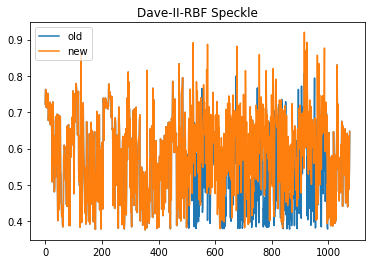

In [53]:
plt.plot(old_results)
plt.plot(new_results)
plt.legend(['old', 'new'])
# plt.title('Dave-II-RBF 200 Brighter')
plt.title('Dave-II-RBF Speckle')
plt.show()

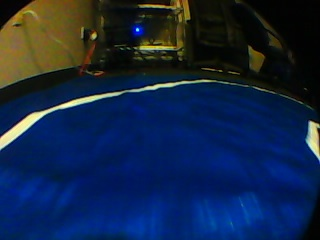

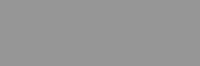

In [20]:
img = cv2.imread('/content/drive/My Drive/Colab Notebooks/DAVE-II-Hunter/DeepNNCar_Train1/frame700.jpg')
cv2_imshow(img)
alpha = 1
beta = 150
img = cv2.resize(img, (200, 66))
new_image = np.zeros(img.shape, np.uint8)
for y in range(img.shape[0]):
    for x in range(img.shape[1]):
        for c in range(img.shape[2]):
            new_image[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)
cv2_imshow(new_image)